In [42]:
#import pylab
import numpy as np
from qiskit import Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
#from qiskit.qobj import RunConfig
from qiskit.tools.visualization import plot_histogram
from qiskit.aqua import QuantumInstance
from qiskit.aqua import run_algorithm
from qiskit.aqua.algorithms import Grover
from qiskit.aqua.components.oracles import  LogicalExpressionOracle
from math import pi, acos, sqrt
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity
from qiskit import BasicAer
from qiskit.quantum_info.operators import Operator
from qiskit.aqua.algorithms.single_sample import QPE
from qiskit.aqua.components.iqfts import Standard
from qiskit.aqua.operators import MatrixOperator
from qiskit.aqua.utils import CircuitFactory
from qiskit.aqua.circuits import PhaseEstimationCircuit
%matplotlib inline

In [43]:
def sprinkler(qc,q,a):
    qc.x(q[2])
    qc.x(a[0])
    qc.x(a[1])
    qc.x(a[2])
    qc.ccx(q[0],q[1],a[0])
    qc.ccx(q[1],q[2],a[1])
    qc.ccx(q[0],q[2],a[2])
    qc.ccx(a[0],a[1],a[3])
    qc.ccx(a[2],a[3],a[4]) #a[4] output
    qc.ccx(a[0],a[1],a[3])
    qc.ccx(q[0],q[2],a[2])
    qc.ccx(q[1],q[2],a[1])
    qc.ccx(q[0],q[1],a[0])
    qc.x(q[2])
    qc.x(a[0])
    qc.x(a[1])
    qc.x(a[2])
    


In [44]:
class cf(CircuitFactory):
    def build(self, qc, q, a):
        qc.x(a[4])
        qc.h(a[4])
        sprinkler(qc,q,a)
        qc.h(a[4])
        qc.x(a[4])
        for i in range(q.size):
            qc.h(q[i])
        for i in range(q.size):
            qc.x(q[i])
        qc.ccx(q[0],q[1],a[5])
        qc.cz(a[5],q[1])
        for i in range(q.size):
            qc.x(q[i])
        qc.ry(2*pi,q[0]) 
        for i in range(q.size):
            qc.h(q[i])

class ini(CircuitFactory):
    def build(self, qc, q, a):
        theta0=2.0*acos(sqrt(0.3));
        theta1=2.0*acos(sqrt(0.2));
        theta2=2.0*acos(sqrt(0.5));
        qc.ry(theta0,q[0]);
        qc.ry(theta1,q[1]);
        qc.ry(theta2,q[2]);

cfs=cf(3)
inis=ini(3)

In [45]:
iqftr=Standard(5)
c=PhaseEstimationCircuit(unitary_circuit_factory=cfs,state_in_circuit_factory=inis,num_ancillae=4,iqft=iqftr,num_time_slices=4)
q=QuantumRegister(3)
a=QuantumRegister(4)
aa=QuantumRegister(6)
cc=c.construct_circuit(q,a,aa,measurement=True)


In [46]:
backend = Aer.get_backend('qasm_simulator')
job_sim = execute(cc, backend, shots=200)

result_sim = job_sim.result()

In [47]:
counts  = result_sim.get_counts(cc)
counts

{'0110': 11,
 '1110': 1,
 '1111': 2,
 '0101': 7,
 '0100': 5,
 '0000': 9,
 '1011': 21,
 '1100': 20,
 '0001': 47,
 '1000': 1,
 '1001': 2,
 '1010': 36,
 '1101': 32,
 '0111': 5,
 '0010': 1}

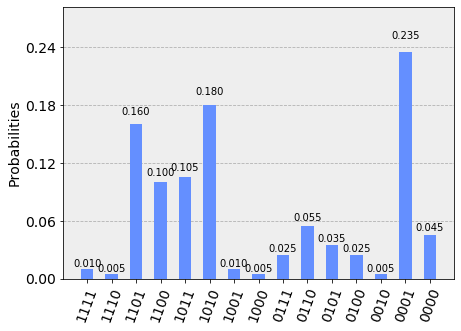

In [48]:
plot_histogram(counts,sort='desc')